In [233]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
import re
from pymystem3 import Mystem
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [234]:
df = pd.read_csv( "feedback.csv",",", 
                 names = ["Mark", "Product", "User", "Date", "Plus", "Minus", "Comment"],
                 header=None, error_bad_lines=False, encoding="utf-8")

In [235]:
# приводим все оценки к двум, до 4 - 0, свыше 4 - 1 
df["target"]=0
df.loc[df.Mark >= 4, "target"] = 1

In [236]:
tokenizer = RegexpTokenizer(u'[A-Za-zА-Яа-яёЁ]+')
m = Mystem()

In [237]:
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    lemms = []
    for i in tokens:
        if len(i)>2:
            lemms.append(m.lemmatize(i)[0])
    return lemms

In [238]:
# определим пол
name_df = pd.read_csv( "russian_names.csv",";", 
                      error_bad_lines=False, encoding="utf-8")
male_df = name_df["Name"][name_df["Sex"]==u"М"].str.lower()
female_df = name_df["Name"][name_df["Sex"]==u"Ж"].str.lower()
male_list = male_df.values.tolist()
female_list = female_df.values.tolist()

In [239]:
def get_sex(name):
    result=-1
    user = name.lower()
    for j in male_list:
        if j == user:
            result=0
            break 
    if result==-1:    
        for j in female_list:
            if j == user:
                result=1
                break    
    if result==-1:
        for j in male_list:
             if j in user:
                result=0
                break         
    if result==-1:
        for j in female_list:
            if j in user:
                result=1
                break         
    return result     

In [240]:
# Объединим все отзывы в одно поле
df2 = pd.DataFrame([], columns=['Plus'])
df2['Plus'] = df['Plus'].fillna('') + ' ' + df['Minus'].fillna('') + ' ' + df['Comment'].fillna('')
df2["target"] = df["target"]

df2["User"] = df["User"]
df2["sex"] = df.apply(lambda x: get_sex(x["User"]), axis=1)
df2.loc[df2['sex'] == -1, 'sex'] = 0
df2.drop('User', axis=1, inplace=True)

#df2 = df[["Plus","target"]]

In [241]:
# делаем все преобразования текста, токенизацию, лематизацию, очистку
df2["Plus"]=df2.apply(lambda x: ' '.join(tokenize(x["Plus"])), axis=1)

In [242]:
stop_words = [u"еще", u"него", u"сказать", u"а", u"ж", u"нее", u"со", u"без", u"же", u"ней", u"совсем", u"более", u"жизнь", u"нельзя", u"так", u"больше", u"за", u"нет", u"такой", u"будет", u"зачем", u"ни", u"там", u"будто", u"здесь", u"нибудь", u"тебя", u"бы", u"и", u"никогда", u"тем", u"был", u"из", u"ним", u"теперь", u"была", u"из", u"за", u"них", u"то", u"были", u"или", u"ничего", u"тогда", u"было", u"им", u"но", u"того", u"быть", u"иногда", u"ну", u"тоже", u"в", u"их", u"о", u"только", u"вам", u"к", u"об", u"том", u"вас", u"кажется", u"один", u"тот", u"вдруг", u"как", u"он", u"три", u"ведь", u"какая", u"она", u"тут", u"во", u"какой", u"они", u"ты", u"вот", u"когда", u"опять", u"у", u"впрочем", u"конечно", u"от", u"уж", u"все", u"которого", u"перед", u"уже", u"всегда", u"которые", u"по", u"хорошо", u"всего", u"кто", u"под", u"хоть", u"всех", u"куда", u"после", u"чего", u"всю", u"ли", u"потом", u"человек", u"вы", u"лучше", u"потому", u"чем", u"г", u"между", u"почти", u"через", u"где", u"меня", u"при", u"что", u"говорил", u"мне", u"про", u"чтоб", u"да", u"много", u"раз", u"чтобы", u"даже", u"может", u"разве", u"чуть", u"два", u"можно", u"с", u"эти", u"для", u"мой", u"сам", u"этого", u"до", u"моя", u"свое", u"этой", u"другой", u"мы", u"свою", u"этом", u"его", u"на", u"себе", u"этот", u"ее", u"над", u"себя", u"эту", u"ей", u"надо", u"сегодня", u"я", u"ему", u"наконец", u"сейчас", u"если", u"нас", u"сказал", u"есть", u"не", u"сказала"]

In [243]:
count_vec2 = CountVectorizer(stop_words=stop_words) #TfidfVectorizer(stop_words=stop_words)

count_vec2_matrix = count_vec2.fit_transform(df2["Plus"]).toarray()

In [244]:
words = [i[0] for i in sorted(count_vec2.vocabulary_.items(), key=lambda x: x[1])]

In [245]:
df3 = pd.DataFrame(count_vec2_matrix, columns=words)

In [246]:
df3["target"]=df2["target"]
df3["sex"]=df2["sex"]

In [247]:
train_df3, test_df3 = train_test_split(df3, test_size=0.20, random_state=873)

In [248]:
Y = train_df3["target"]
train_df3.drop('target', axis=1, inplace=True)

In [249]:
y = test_df3["target"]
test_df3.drop('target', axis=1, inplace=True)

In [250]:
RandomForest3 = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, \
                                      random_state=57, n_jobs=100)
RandomForest3.fit(train_df3, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=100, oob_score=False, random_state=57,
            verbose=0, warm_start=False)

In [251]:
RandomForest_pred = RandomForest3.predict(test_df3)
RandomForest_pred_proba = RandomForest3.predict_proba(test_df3)[:,1]

In [252]:
PPV = metrics.precision_score(y, RandomForest_pred)
TPR = metrics.recall_score(y, RandomForest_pred)
F1 = metrics.f1_score(y, RandomForest_pred)
ACC = metrics.accuracy_score(y, RandomForest_pred)
PPV, TPR, F1, ACC

(0.84464230887319625,
 0.98214923241699392,
 0.908220534829977,
 0.84846007086399566)

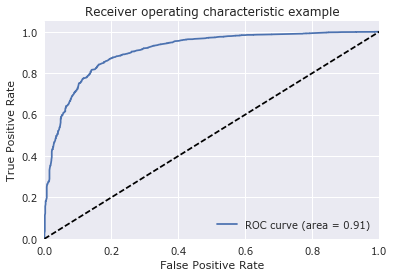

In [253]:
# Compute ROC curve and ROC area
# fpr, tpr, _ = roc_curve( y, RandomForest_pred_proba.flatten('F')[97825:])
fpr, tpr, _ = roc_curve(y, RandomForest_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [254]:
roc_auc

0.90930658405408216

Feature ranking:
0. отличный 0.012586 
1. довольный 0.010378 
2. сломаться 0.009265 
3. ужасный 0.008367 
4. хороший 0.007684 
5. переставать 0.006873 
6. очень 0.006393 
7. супер 0.005393 
8. отлично 0.004946 
9. прорабатывать 0.004625 
10. вернуть 0.004341 
11. начинать 0.004313 
12. сдавать 0.003959 
13. ремонт 0.003899 
14. отвратительный 0.003869 
15. месяц 0.003832 
16. плохо 0.003748 
17. пользоваться 0.003735 
18. удобный 0.003576 
19. год 0.003437 
20. sex 0.003406 
21. это 0.003164 
22. купить 0.003115 
23. ужас 0.003114 
24. плохой 0.002972 
25. приходиться 0.002955 
26. сгорать 0.002909 
27. потечь 0.002909 
28. менять 0.002855 
29. работать 0.002836 
30. поменять 0.002818 
31. обратно 0.002722 
32. цена 0.002581 
33. невозможно 0.002524 
34. становиться 0.002430 
35. рекомендовать 0.002385 
36. разочаровывать 0.002227 
37. деньги 0.002191 
38. пожалеть 0.002126 
39. просто 0.002123 
40. ужасно 0.002099 
41. возвращать 0.002000 
42. разочарованный 0.001982 
43. нравиться 0.

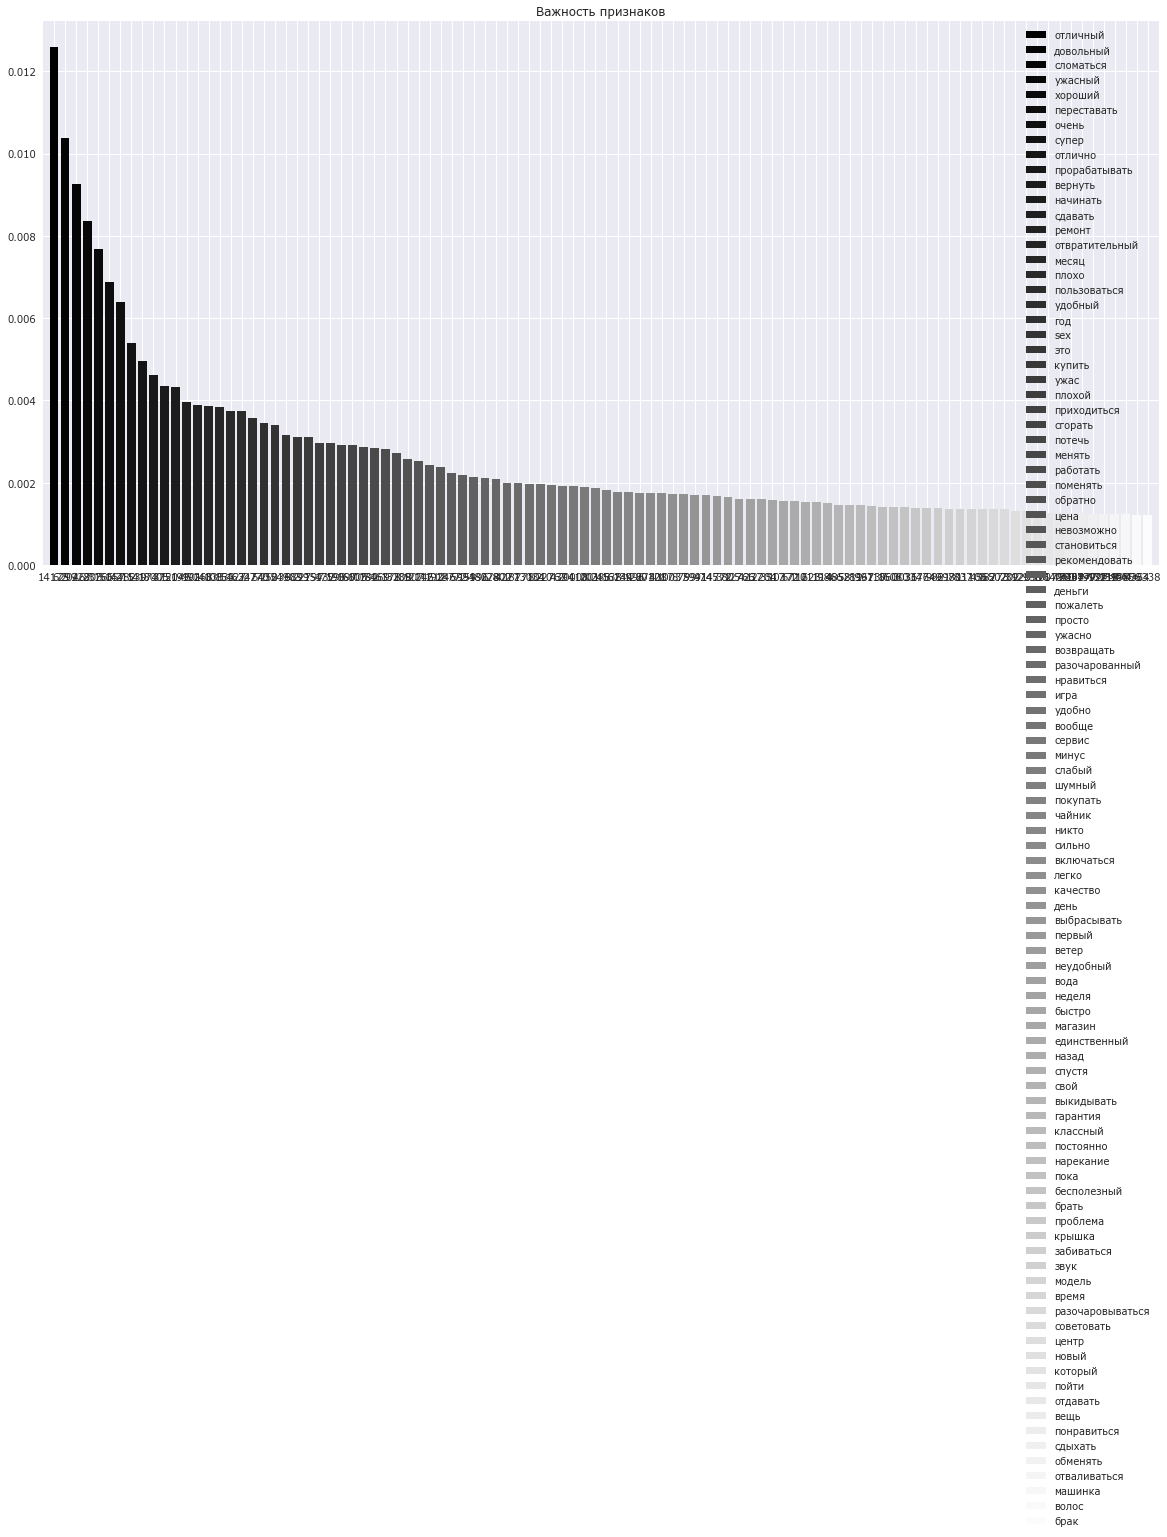

In [255]:
importances = RandomForest3.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = 100
feature_indices = [ind for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f, 
            list(train_df3)[indices[f]], 
            importances[indices[f]]))
plt.figure(figsize=(20,10))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(list(train_df3)[i]) 
                  for i in feature_indices]);

In [271]:
cross_val_score(RandomForest3, test_df3, y, cv=5, scoring='roc_auc').mean()

0.86335568145421249